# Задание 5.1 - Word2Vec

В этом задании мы натренируем свои word vectors на очень небольшом датасете.
Мы будем использовать самую простую версию word2vec, без negative sampling и других оптимизаций.

Перед запуском нужно запустить скрипт `download_data.sh` чтобы скачать данные.

Датасет и модель очень небольшие, поэтому это задание можно выполнить и без GPU.

In [1]:
!wget "http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip"
!unzip -q "stanfordSentimentTreebank.zip"


--2021-05-16 16:20:48--  http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip [following]
--2021-05-16 16:20:48--  https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6372817 (6.1M) [application/zip]
Saving to: ‘stanfordSentimentTreebank.zip.1’

stanfordSentimentTr 100%[===================>]   6.08M  9.69MB/s    in 0.6s    

2021-05-16 16:20:49 (9.69 MB/s) - ‘stanfordSentimentTreebank.zip.1’ saved [6372817/6372817]

replace stanfordSentimentTreebank/datasetSentences.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

# We'll use Principal Component Analysis (PCA) to visualize word vectors,
# so make sure you install dependencies from requirements.txt!
from sklearn.decomposition import PCA 

%matplotlib inline

In [3]:
import os
import numpy as np

class StanfordTreeBank:
    '''
    Wrapper for accessing Stanford Tree Bank Dataset
    https://nlp.stanford.edu/sentiment/treebank.html
    
    Parses dataset, gives each token and index and provides lookups
    from string token to index and back
    
    Allows to generate random context with sampling strategy described in
    word2vec paper:
    https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
    '''
    def __init__(self):
        self.index_by_token = {}
        self.token_by_index = []

        self.sentences = []

        self.token_freq = {}
        
        self.token_reject_by_index = None

    def load_dataset(self, folder):
        filename = os.path.join(folder, "datasetSentences.txt")

        with open(filename, "r", encoding="latin1") as f:
            l = f.readline() # skip the first line
            
            for l in f:
                splitted_line = l.strip().split()
                words = [w.lower() for w in splitted_line[1:]] # First one is a number
                    
                self.sentences.append(words)
                for word in words:
                    if word in self.token_freq:
                        self.token_freq[word] +=1 
                    else:
                        index = len(self.token_by_index)
                        self.token_freq[word] = 1
                        self.index_by_token[word] = index
                        self.token_by_index.append(word)
        self.compute_token_prob()
                        
    def compute_token_prob(self):
        words_count = np.array([self.token_freq[token] for token in self.token_by_index])
        words_freq = words_count / np.sum(words_count)
        
        # Following sampling strategy from word2vec paper:
        # https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
        self.token_reject_by_index = 1- np.sqrt(1e-5/words_freq)
    
    def check_reject(self, word):
        return np.random.rand() > self.token_reject_by_index[self.index_by_token[word]]
        
    def get_random_context(self, context_length=5):
        """
        Returns tuple of center word and list of context words
        """
        sentence_sampled = []
        while len(sentence_sampled) <= 2:
            sentence_index = np.random.randint(len(self.sentences)) 
            sentence = self.sentences[sentence_index]
            sentence_sampled = [word for word in sentence if self.check_reject(word)]
    
        center_word_index = np.random.randint(len(sentence_sampled))
        
        words_before = sentence_sampled[max(center_word_index - context_length//2,0):center_word_index]
        words_after = sentence_sampled[center_word_index+1: center_word_index+1+context_length//2]
        
        return sentence_sampled[center_word_index], words_before+words_after
    
    def num_tokens(self):
        return len(self.token_by_index)
        
data = StanfordTreeBank()
data.load_dataset("./stanfordSentimentTreebank/")

print("Num tokens:", data.num_tokens())
for i in range(5):
    center_word, other_words = data.get_random_context(5)
    print(center_word, other_words)
device = torch.device("cuda:0") # Let's make sure GPU is available!
device

Num tokens: 19538
anybody ['`', 'reality', 'contemplating', 'drastic']
spirit ['revives', 'free-wheeling']
inherently ['caustic', 'chimes']
coarse ['cartoon', 'shameless']
spouting ['therapy-dependent', 'flakeball', 'malapropisms', '...']


device(type='cuda', index=0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Имплеменируем PyTorch-style Dataset для Word2Vec

Этот Dataset должен сгенерировать много случайных контекстов и превратить их в сэмплы для тренировки.

Напоминаем, что word2vec модель получает на вход One-hot вектор слова и тренирует простую сеть для предсказания на его основе соседних слов.
Из набора слово-контекст создается N сэмплов (где N - количество слов в контексте):

Например:

Слово: `orders` и контекст: `['love', 'nicest', 'to', '50-year']` создадут 4 сэмпла:
- input: `orders`, target: `love`
- input: `orders`, target: `nicest`
- input: `orders`, target: `to`
- input: `orders`, target: `50-year`

Все слова на входе и на выходе закодированы через one-hot encoding, с размером вектора равным количеству токенов.

In [4]:
class Word2VecPlain(Dataset):
    '''
    PyTorch Dataset for plain Word2Vec.
    Accepts StanfordTreebank as data and is able to generate dataset based on
    a number of random contexts
    '''
    def __init__(self, data, num_contexts=30000):
        '''
        Initializes Word2VecPlain, but doesn't generate the samples yet
        (for that, use generate_dataset)
        Arguments:
        data - StanfordTreebank instace
        num_contexts - number of random contexts to use when generating a dataset
        '''
        self.data = data
        self.num_contexts = num_contexts
        self.num_tokens = len(data.index_by_token)
        self.samples = []
    
        '''
        Generates dataset samples from random contexts
        Note: there will be more samples than contexts because every context
        can generate more than one sample
        '''
    def generate_dataset(self):
      for i in range(self.num_contexts):
        center_word, context_words = data.get_random_context()
        for j in context_words:
          sample = (self.data.index_by_token[center_word], self.data.index_by_token[j])
          self.samples.append(sample)
        
    def __len__(self):
        '''
        Returns total number of samples
        '''
        return len(self.samples)
    
    def __getitem__(self, index):
        '''
        Returns i-th sample
        
        Return values:
        input_vector - torch.Tensor with one-hot representation of the input vector
        output_index - index of the target word (not torch.Tensor!)
        '''
        input_index, output_index = self.samples[index]
        input_vector = torch.zeros(self.num_tokens)
        input_vector[input_index] = 1.0
        return input_vector, output_index   

dataset = Word2VecPlain(data, 10)
dataset.generate_dataset()
input_vector, target = dataset[3]
print("Sample - input: %s, target: %s" % (input_vector, int(target))) # target should be able to convert to int
assert isinstance(input_vector, torch.Tensor)
assert torch.sum(input_vector) == 1.0
assert input_vector.shape[0] == data.num_tokens()

Sample - input: tensor([0., 0., 0.,  ..., 0., 0., 0.]), target: 7922


# Создаем модель и тренируем ее

In [5]:
# Create the usual PyTorch structures
dataset = Word2VecPlain(data, 30000)
dataset.generate_dataset()

# We'll be training very small word vectors!
wordvec_dim = 10

# We can use a standard sequential model for this
nn_model = nn.Sequential(
            nn.Linear(dataset.num_tokens, wordvec_dim, bias=False),
            nn.Linear(wordvec_dim, dataset.num_tokens, bias=False), 
         )
nn_model.type(torch.FloatTensor)

Sequential(
  (0): Linear(in_features=19538, out_features=10, bias=False)
  (1): Linear(in_features=10, out_features=19538, bias=False)
)

In [6]:
def extract_word_vectors(nn_model):
    '''
    Extracts word vectors from the model
    
    Returns:
    input_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    output_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    '''
    weights = list()
    for layer in nn_model.children():
        parameter = list(layer.parameters())
        weights.append(parameter[0])
    return weights[0].T, weights[1]

untrained_input_vectors, untrained_output_vectors = extract_word_vectors(nn_model)
assert untrained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert untrained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

In [7]:
def train_model(model, dataset, train_loader, optimizer, scheduler, num_epochs):
    '''
    Trains plain word2vec using cross-entropy loss and regenerating dataset every epoch
    
    Returns:
    loss_history, train_history
    '''
    
    loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
    
    loss_history = []
    train_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        dataset.generate_dataset() # Regenerate dataset every epoch
        train_loader = torch.utils.data.DataLoader(dataset, batch_size= 15)
        # TODO Implement training for this model
        # Note we don't have any validation set here because our purpose is the word vectors,
        # not the predictive performance of the model
        #
        # And don't forget to step the learing rate scheduler!  
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        
        for i_step, (x, y) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            _, indices = torch.max(prediction, 1)
            correct_samples += float (torch.sum(indices == y_gpu))
            total_samples += float (y.shape[0])
            loss_accum += float( loss_value )
            
            del prediction
            del loss_value
            del _, indices
                      
        ave_loss = float(loss_accum) / float(i_step)
        train_accuracy = float(correct_samples) / float(total_samples)
        scheduler.step()
         
        loss_history.append(float(ave_loss))
        train_history.append(float(train_accuracy))
        
        print("Epoch %i, Average loss: %f, Train accuracy: %f" % (epoch, ave_loss, train_accuracy))
        
    return loss_history, train_history

In [ ]:
device

device(type='cuda', index=0)

# Ну и наконец тренировка!

Добейтесь значения ошибки меньше **8.0**.

In [ ]:
# Finally, let's train the model!

# TODO: We use placeholder values for hyperparameters - you will need to find better values!
optimizer = optim.SGD(nn_model.parameters(), lr=22e-2, weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=14)
#КУДА РАБОТАЙ!!!! ТЕБЯ УЖЕ 1 РАЗ ВКЛЮЧИЛИ!!!!
#cuda = "cuda:0"
#device = torch.device(cude) # Let's make sure GPU is available!
device
nn_model=nn_model.to(device)
loss_history, train_history = train_model(nn_model, dataset, train_loader, optimizer, scheduler, 20)

Epoch 0, Average loss: 9.808835, Train accuracy: 0.005283
Epoch 1, Average loss: 9.649967, Train accuracy: 0.005438
Epoch 2, Average loss: 9.445754, Train accuracy: 0.005333
Epoch 3, Average loss: 9.285900, Train accuracy: 0.005529
Epoch 4, Average loss: 9.138189, Train accuracy: 0.006239
Epoch 5, Average loss: 8.970345, Train accuracy: 0.008608
Epoch 6, Average loss: 8.783996, Train accuracy: 0.012526
Epoch 7, Average loss: 8.598095, Train accuracy: 0.017739
Epoch 8, Average loss: 8.426422, Train accuracy: 0.023110
Epoch 9, Average loss: 8.273846, Train accuracy: 0.027565
Epoch 10, Average loss: 8.154571, Train accuracy: 0.031313
Epoch 11, Average loss: 8.147629, Train accuracy: 0.031645
Epoch 12, Average loss: 8.139925, Train accuracy: 0.031981
Epoch 13, Average loss: 8.130667, Train accuracy: 0.032235
Epoch 14, Average loss: 8.119936, Train accuracy: 0.032528
Epoch 15, Average loss: 8.109662, Train accuracy: 0.032751
Epoch 16, Average loss: 8.097436, Train accuracy: 0.033008
Epoch 1

In [17]:
nn_model_1 = nn.Sequential(
            nn.Linear(dataset.num_tokens, wordvec_dim, bias=False),
            nn.Linear(wordvec_dim, dataset.num_tokens, bias=False), 
         )
nn_model_1.type(torch.FloatTensor)
optimizer = optim.SGD(nn_model_1.parameters(), lr=2e-1, weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
train_loader = torch.utils.data.DataLoader(dataset, batch_size = 20)
device
nn_model_1=nn_model_1.to(device)
loss_history, train_history = train_model(nn_model_1, dataset, train_loader, optimizer, scheduler, 10)

Epoch 0, Average loss: 9.814774, Train accuracy: 0.003233
Epoch 1, Average loss: 9.350996, Train accuracy: 0.004067
Epoch 2, Average loss: 8.932399, Train accuracy: 0.008567
Epoch 3, Average loss: 8.486465, Train accuracy: 0.020385
Epoch 4, Average loss: 8.161997, Train accuracy: 0.029552
Epoch 5, Average loss: 7.987215, Train accuracy: 0.034619
Epoch 6, Average loss: 7.960184, Train accuracy: 0.035312
Epoch 7, Average loss: 7.937709, Train accuracy: 0.035768
Epoch 8, Average loss: 7.916523, Train accuracy: 0.036169
Epoch 9, Average loss: 7.895815, Train accuracy: 0.036653


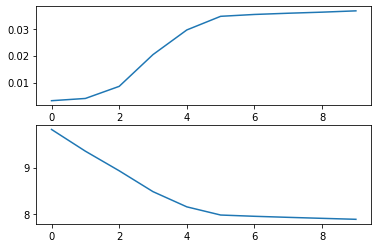

In [18]:
# Visualize training graphs
plt.subplot(211)
plt.plot(train_history)
plt.subplot(212)
plt.plot(loss_history)

# Визуализируем вектора для разного вида слов до и после тренировки

В случае успешной тренировки вы должны увидеть как вектора слов разных типов (например, знаков препинания, предлогов и остальных) разделяются семантически.

Студенты - в качестве выполненного задания присылайте notebook с диаграммами!

In [10]:
def extract_word_vectors(nn_model_1):
    '''
    Extracts word vectors from the model
    
    Returns:
    input_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    output_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    '''
    weights = list()
    for layer in nn_model_1.children():
        parameter = list(layer.parameters())
        weights.append(parameter[0])
    return weights[0].T, weights[1]


In [11]:
nn_model_1 = nn.Sequential(
            nn.Linear(dataset.num_tokens, wordvec_dim, bias=False),
            nn.Linear(wordvec_dim, dataset.num_tokens, bias=False), 
         )
nn_model_1.type(torch.FloatTensor)

untrained_input_vectors, untrained_output_vectors = extract_word_vectors(nn_model_1)
assert untrained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert untrained_output_vectors.shape == (data.num_tokens(), wordvec_dim)
optimizer = optim.SGD(nn_model_1.parameters(), lr=2e-1, weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
train_loader = torch.utils.data.DataLoader(dataset, batch_size = 20)
device
nn_model_1=nn_model_1.to(device)
loss_history, train_history = train_model(nn_model_1, dataset, train_loader, optimizer, scheduler, 7)

Epoch 0, Average loss: 9.880112, Train accuracy: 0.000411
Epoch 1, Average loss: 9.874535, Train accuracy: 0.001832
Epoch 2, Average loss: 9.868180, Train accuracy: 0.003000
Epoch 3, Average loss: 9.858971, Train accuracy: 0.004332
Epoch 4, Average loss: 9.836138, Train accuracy: 0.005547
Epoch 5, Average loss: 9.804472, Train accuracy: 0.005830
Epoch 6, Average loss: 9.797340, Train accuracy: 0.005600


Epoch 0, Average loss: 9.793394, Train accuracy: 0.005479
Epoch 1, Average loss: 9.795224, Train accuracy: 0.005296


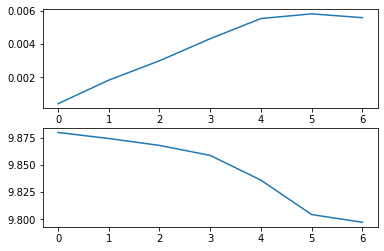

In [14]:
# Visualize training graphs
optimizer = optim.SGD(nn_model.parameters(), lr=15e-2, weight_decay=0)
loss_history_, train_history_ = train_model(nn_model_1, dataset, train_loader, optimizer, scheduler, 2)

In [15]:
optimizer = optim.SGD(nn_model.parameters(), lr=22e-2, weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss_history_2, train_history_2 = train_model(nn_model_1, dataset, train_loader, optimizer, scheduler, 10)
plt.subplot(211)
plt.plot([*train_history , *train_history_, *train_history_2])
plt.subplot(212)
plt.plot([*loss_history , *loss_history_, *loss_history_2])

Epoch 0, Average loss: 9.796804, Train accuracy: 0.005124
Epoch 1, Average loss: 9.798226, Train accuracy: 0.004987
Epoch 2, Average loss: 9.799399, Train accuracy: 0.004867
Epoch 3, Average loss: 9.800376, Train accuracy: 0.004754
Epoch 4, Average loss: 9.801334, Train accuracy: 0.004669


KeyboardInterrupt: ignored

In [24]:
# Finally, let's train the model!

# TODO: We use placeholder values for hyperparameters - you will need to find better values!
optimizer = optim.SGD(nn_model.parameters(), lr=22e-2, weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=14)
#КУДА РАБОТАЙ!!!! ТЕБЯ УЖЕ 1 РАЗ ВКЛЮЧИЛИ!!!!
#cuda = "cuda:0"
#device = torch.device(cude) # Let's make sure GPU is available!
device
nn_model=nn_model.to(device)
loss_history, train_history = train_model(nn_model, dataset, train_loader, optimizer, scheduler, 20)

Epoch 0, Average loss: 9.879983, Train accuracy: 0.000477
Epoch 1, Average loss: 9.873860, Train accuracy: 0.001861
Epoch 2, Average loss: 9.866673, Train accuracy: 0.003216
Epoch 3, Average loss: 9.855264, Train accuracy: 0.004922
Epoch 4, Average loss: 9.821095, Train accuracy: 0.005709
Epoch 5, Average loss: 9.715156, Train accuracy: 0.005764
Epoch 6, Average loss: 9.544065, Train accuracy: 0.005583
Epoch 7, Average loss: 9.385562, Train accuracy: 0.005444
Epoch 8, Average loss: 9.253275, Train accuracy: 0.005697
Epoch 9, Average loss: 9.117992, Train accuracy: 0.006558
Epoch 10, Average loss: 9.016864, Train accuracy: 0.007912
Epoch 11, Average loss: 9.007785, Train accuracy: 0.008007
Epoch 12, Average loss: 8.996372, Train accuracy: 0.008149


KeyboardInterrupt: ignored

In [8]:
# Finally, let's train the model!

# TODO: We use placeholder values for hyperparameters - you will need to find better values!
optimizer = optim.SGD(nn_model.parameters(), lr=5.0, weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.4)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=20)
#КУДА РАБОТАЙ!!!! ТЕБЯ УЖЕ 1 РАЗ ВКЛЮЧИЛИ!!!!
#cuda = "cuda:0"
#device = torch.device(cude) # Let's make sure GPU is available!
device
nn_model=nn_model.to(device)
loss_history, train_history = train_model(nn_model, dataset, train_loader, optimizer, scheduler, 25)

Epoch 0, Average loss: 9.776002, Train accuracy: 0.001607
Epoch 1, Average loss: 9.291999, Train accuracy: 0.007929
Epoch 2, Average loss: 9.079731, Train accuracy: 0.010747
Epoch 3, Average loss: 9.045064, Train accuracy: 0.011361
Epoch 4, Average loss: 9.031207, Train accuracy: 0.011599
Epoch 5, Average loss: 9.027185, Train accuracy: 0.011654
Epoch 6, Average loss: 9.022566, Train accuracy: 0.011609
Epoch 7, Average loss: 9.018851, Train accuracy: 0.011600
Epoch 8, Average loss: 9.017052, Train accuracy: 0.011622
Epoch 9, Average loss: 9.014935, Train accuracy: 0.011627
Epoch 10, Average loss: 8.184608, Train accuracy: 0.024919
Epoch 11, Average loss: 8.051704, Train accuracy: 0.028597
Epoch 12, Average loss: 8.034611, Train accuracy: 0.029649
Epoch 13, Average loss: 8.027836, Train accuracy: 0.030149
Epoch 14, Average loss: 8.024526, Train accuracy: 0.030327
Epoch 15, Average loss: 8.022134, Train accuracy: 0.030544
Epoch 16, Average loss: 8.021011, Train accuracy: 0.030574
Epoch 1

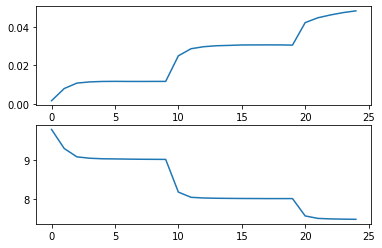

In [16]:
plt.subplot(211)
plt.plot(train_history)
plt.subplot(212)
plt.plot(loss_history)

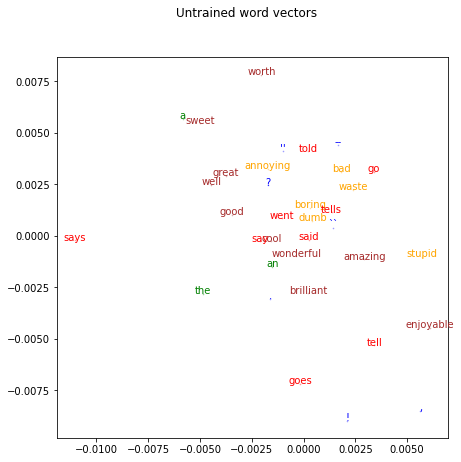

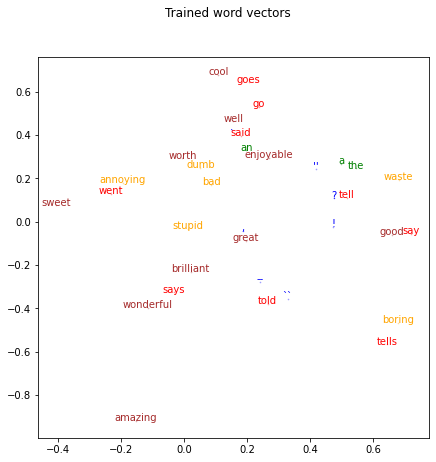

In [25]:
trained_input_vectors, trained_output_vectors = extract_word_vectors(nn_model)
assert trained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert trained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

def visualize_vectors(input_vectors, output_vectors, title=''):
    full_vectors = torch.cat((input_vectors, output_vectors), 0)
    wordvec_embedding = PCA(n_components=2).fit_transform(full_vectors.detach().numpy())

    # Helpful words form CS244D example
    # http://cs224d.stanford.edu/assignment1/index.html
    visualize_words = {'green': ["the", "a", "an"], 
                      'blue': [",", ".", "?", "!", "``", "''", "--"], 
                      'brown': ["good", "great", "cool", "brilliant", "wonderful", 
                              "well", "amazing", "worth", "sweet", "enjoyable"],
                      'orange': ["boring", "bad", "waste", "dumb", "annoying", "stupid"],
                      'red': ['tell', 'told', 'said', 'say', 'says', 'tells', 'goes', 'go', 'went']
                     }

    plt.figure(figsize=(7,7))
    plt.suptitle(title)
    for color, words in visualize_words.items():
        points = np.array([wordvec_embedding[data.index_by_token[w]] for w in words])
        for i, word in enumerate(words):
            plt.text(points[i, 0], points[i, 1], word, color=color,horizontalalignment='center')
        plt.scatter(points[:, 0], points[:, 1], c=color, alpha=0.3, s=0.5)
#ПОЧЕМУ ТАК? RuntimeError: All input tensors must be on the same device. Received cpu and cuda:0
#попытка №20
tmp=untrained_input_vectors
tmp_2=untrained_output_vectors
tmp=tmp.to(device)
tmp_2=tmp_2.to(device)
visualize_vectors(torch.clone(tmp.cpu()), torch.clone(tmp_2.cpu()), "Untrained word vectors")
tmp=trained_input_vectors
tmp_2=trained_output_vectors
tmp=tmp.to(device)
tmp_2=tmp_2.to(device)
visualize_vectors(torch.clone(tmp.cpu()), torch.clone(tmp_2.cpu()), "Trained word vectors")